In [6]:
import cv2
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader, Dataset
import torchvision
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
from torch.utils.data import random_split, DataLoader
from PIL import Image

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import cv2
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
from torch.utils.data import random_split, DataLoader, Dataset
import torchvision
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
from torch.utils.data import random_split, DataLoader
from PIL import Image

#Warnings
import warnings
warnings.filterwarnings('ignore')


#Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('python: {}, torch: {}, torchvision: {}'.format(sys.version, torch.__version__, torchvision.__version__))

torch.cuda.is_available()

python: 3.8.18 (default, Sep 11 2023, 13:40:15) 
[GCC 11.2.0], torch: 2.1.0+cu121, torchvision: 0.16.0+cu121


False

In [10]:
import os
data='/Users/sowmiyanarayanselvam/Documents/AirCloud/Rutgers/Spring24/ML2/Project/ML/dataset/asl_alphabet_train/asl_alphabet_train'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    print(folds)
    folds.remove('.DS_Store')
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)

        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)



# Create DataFrames for train, test, and val
df = create_dataframe(data)

df.to_pickle('/Users/sowmiyanarayanselvam/Documents/AirCloud/Rutgers/Spring24/ML2/Project/ML/data.pkl')

['.DS_Store', 'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W']


In [4]:
import os
test = '/Users/sowmiyanarayanselvam/Documents/AirCloud/Rutgers/Spring24/ML2/Project/ML/dataset/asl_alphabet_test/asl_alphabet_test'

def create_test_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    imgs = os.listdir(data_path)
        
    # Iterate through images in the subfolder
    for img in imgs:
        img_path = os.path.join(data_path, img)
        
        # Append image path and corresponding label
        filepaths.append(img_path)
        labels.append(img.split('_')[0])

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)


df_test = create_test_dataframe(test)
print(df_test.head)
df_test.to_pickle('/Users/sowmiyanarayanselvam/Documents/AirCloud/Rutgers/Spring24/ML 2/Project/ML/test.pkl')

<bound method NDFrame.head of                                             Filepaths   Labels
0   /Users/sowmiyanarayanselvam/Documents/AirCloud...        F
1   /Users/sowmiyanarayanselvam/Documents/AirCloud...        G
2   /Users/sowmiyanarayanselvam/Documents/AirCloud...        L
3   /Users/sowmiyanarayanselvam/Documents/AirCloud...        M
4   /Users/sowmiyanarayanselvam/Documents/AirCloud...        R
5   /Users/sowmiyanarayanselvam/Documents/AirCloud...        S
6   /Users/sowmiyanarayanselvam/Documents/AirCloud...        X
7   /Users/sowmiyanarayanselvam/Documents/AirCloud...        Y
8   /Users/sowmiyanarayanselvam/Documents/AirCloud...        U
9   /Users/sowmiyanarayanselvam/Documents/AirCloud...        T
10  /Users/sowmiyanarayanselvam/Documents/AirCloud...        A
11  /Users/sowmiyanarayanselvam/Documents/AirCloud...        K
12  /Users/sowmiyanarayanselvam/Documents/AirCloud...        J
13  /Users/sowmiyanarayanselvam/Documents/AirCloud...        Z
14  /Users/sowmiyanarayan

In [39]:
train_set, val_set = random_split(df, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
# print(type(train_set))
train_df = df.iloc[train_set.indices]
val_df = df.iloc[val_set.indices]


<class 'torch.utils.data.dataset.Subset'>


In [40]:
print(type(train_df))

<class 'pandas.core.frame.DataFrame'>


In [60]:
class CustomDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_path = self.data_df.iloc[idx, 0]  # Assuming the first column contains file paths
        label = self.data_df.iloc[idx, 1]  # Assuming the second column contains labels
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Assuming df contains image file paths and labels
train_dataset = CustomDataset(train_df, transform=transform)
valid_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(df_test, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, pin_memory=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True, pin_memory=True, num_workers=4)


In [56]:
print(len(train_dataset))
print(len(train_loader))

69600
1392


(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


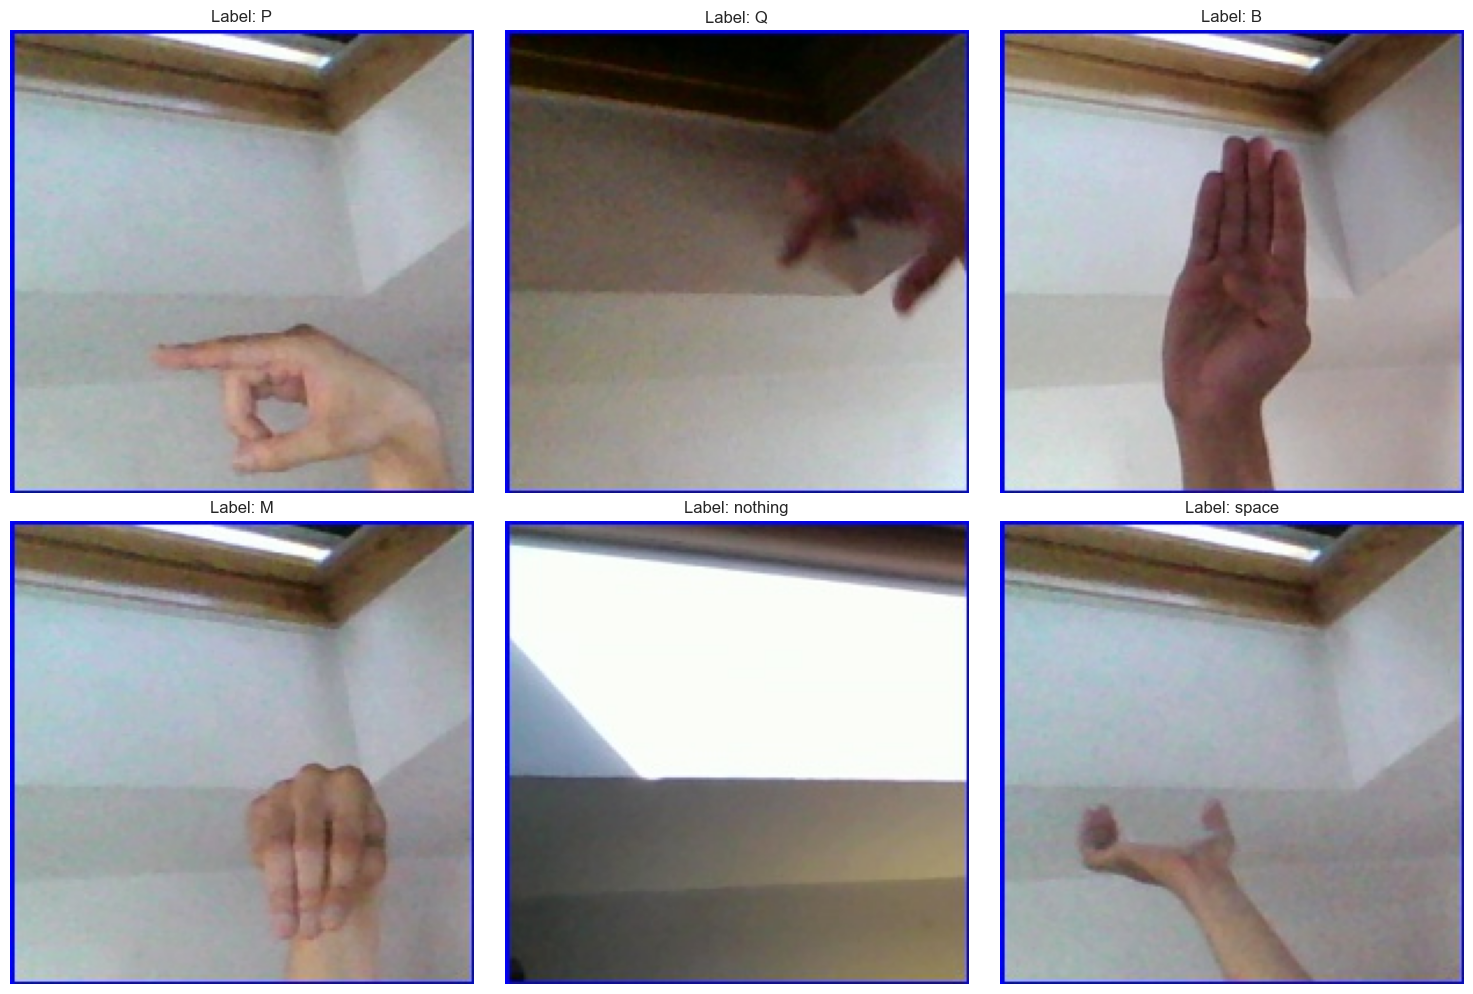

In [11]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        print(img.shape)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(df)

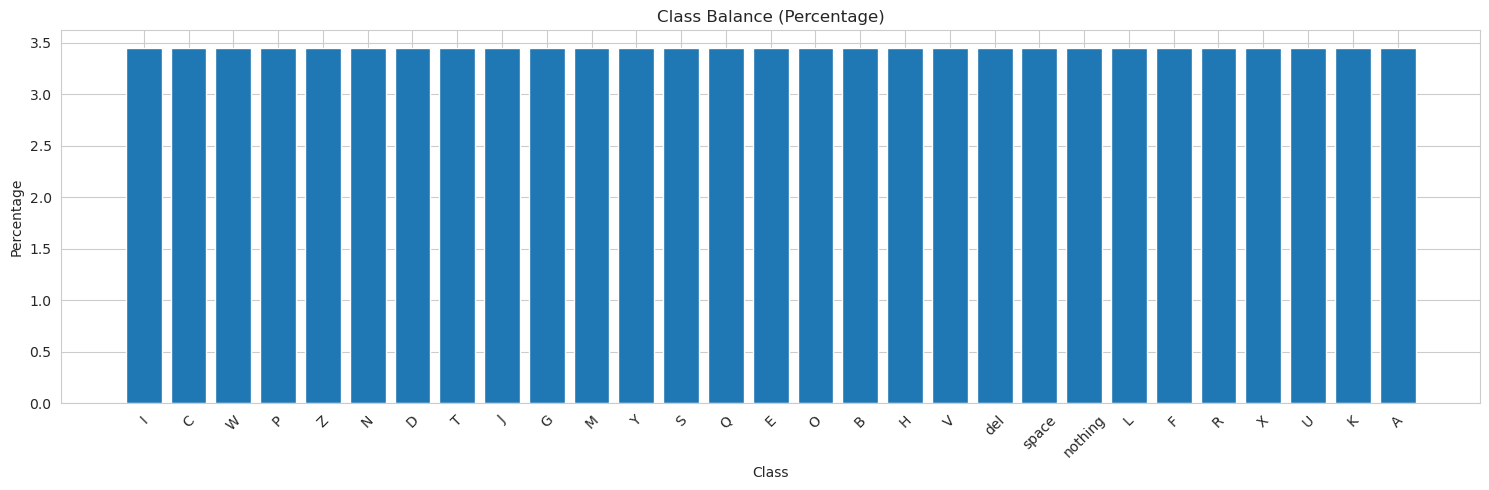

In [9]:
# Calculate class counts
class_counts = df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(df)

# # Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# # Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# # Create the bar chart using matplotlib
plt.figure(figsize=(15, 5))
plt.bar(class_counts['Class'], class_counts['Percentage'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Balance (Percentage)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

In [ ]:
# base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
#                                                      pooling = 'max' )

# model = nn.Sequential([
#     base_model,
#     nn.BatchNormalization(),
#     nn.Dense(256,activation = 'relu'),
#     nn.Dropout(.5),
#     nn.Dense(29 , activation= 'softmax' )
# ])

# model.compile(optim.Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
# history = model.fit(
#     x= train_loader ,
#     validation_data= valid_loader ,
#     epochs= 5 , verbose = 1 ,
#     validation_steps= None, shuffle= False
#    )

In [71]:
for batch, (images, labels) in enumerate(valid_loader):
    print(batch, images.shape, labels)

0 torch.Size([50, 3, 150, 150]) ('F', 'nothing', 'space', 'V', 'K', 'S', 'Z', 'space', 'N', 'R', 'J', 'Y', 'J', 'M', 'V', 'del', 'R', 'J', 'D', 'del', 'K', 'F', 'S', 'W', 'Q', 'L', 'Z', 'nothing', 'D', 'N', 'L', 'X', 'Z', 'M', 'V', 'Z', 'Q', 'L', 'W', 'Y', 'Z', 'A', 'B', 'Z', 'E', 'C', 'T', 'W', 'M', 'A')
1 torch.Size([50, 3, 150, 150]) ('R', 'space', 'C', 'K', 'Z', 'U', 'V', 'Q', 'R', 'D', 'E', 'del', 'O', 'K', 'S', 'space', 'C', 'F', 'Z', 'J', 'S', 'S', 'G', 'O', 'C', 'L', 'W', 'I', 'B', 'Q', 'P', 'space', 'S', 'K', 'K', 'T', 'K', 'B', 'H', 'S', 'O', 'space', 'P', 'V', 'B', 'G', 'E', 'B', 'K', 'U')
2 torch.Size([50, 3, 150, 150]) ('S', 'T', 'F', 'P', 'K', 'T', 'L', 'L', 'I', 'I', 'nothing', 'N', 'del', 'E', 'L', 'X', 'F', 'O', 'Y', 'Q', 'H', 'C', 'X', 'G', 'A', 'X', 'A', 'nothing', 'X', 'D', 'O', 'C', 'Q', 'space', 'P', 'A', 'J', 'F', 'G', 'D', 'B', 'K', 'P', 'del', 'S', 'U', 'E', 'Q', 'T', 'U')
3 torch.Size([50, 3, 150, 150]) ('K', 'V', 'B', 'del', 'A', 'N', 'A', 'T', 'Q', 'H', 'R',

KeyboardInterrupt: 

In [11]:
base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT, pretrained=True)
num_features = base_model.fc.in_features
base_model.fc = nn.Identity()
base_model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1)) 


model = nn.Sequential(
    base_model,
    nn.BatchNorm1d(num_features),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 29),
    nn.Softmax(dim=1)
)
model = model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adamax(model.parameters(),lr=0.0001, weight_decay=1e-4)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

# Example of how you can use accuracy as a metric
def eval_acc(model, data_loader):

  with torch.no_grad():
    model.eval()

    total = 0
    correct = 0

    for (images, labels) in data_loader:
        images = images.cuda()
        labels = labels.cuda()

        labels_pred = model.predict(images)

        total += labels.shape[0]
        correct += (labels_pred == labels).sum().item()

    acc = 100 * correct / total

  return acc

loss_history=[]

num_epochs = 5
for epoch in range(num_epochs):
    val_acc = eval_acc(model, valid_loader)
    model.train()
    running_loss = 0.0
    
    for batch, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            loss_history.append(loss.item())
            if batch == 0:
                print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
                  epoch, loss.item(), val_acc))
                

    epoch_loss = running_loss / len(train_loader.dataset)

  

with torch.no_grad():
    plt.plot(loss_history, 'o')
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()



TypeError: list indices must be integers or slices, not tuple

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

174/174 ━━━━━━━━━━━━━━━━━━━━ 61s 354ms/step - accuracy: 0.9998 - loss: 0.0019
Test Accuracy: 0.9997701048851013


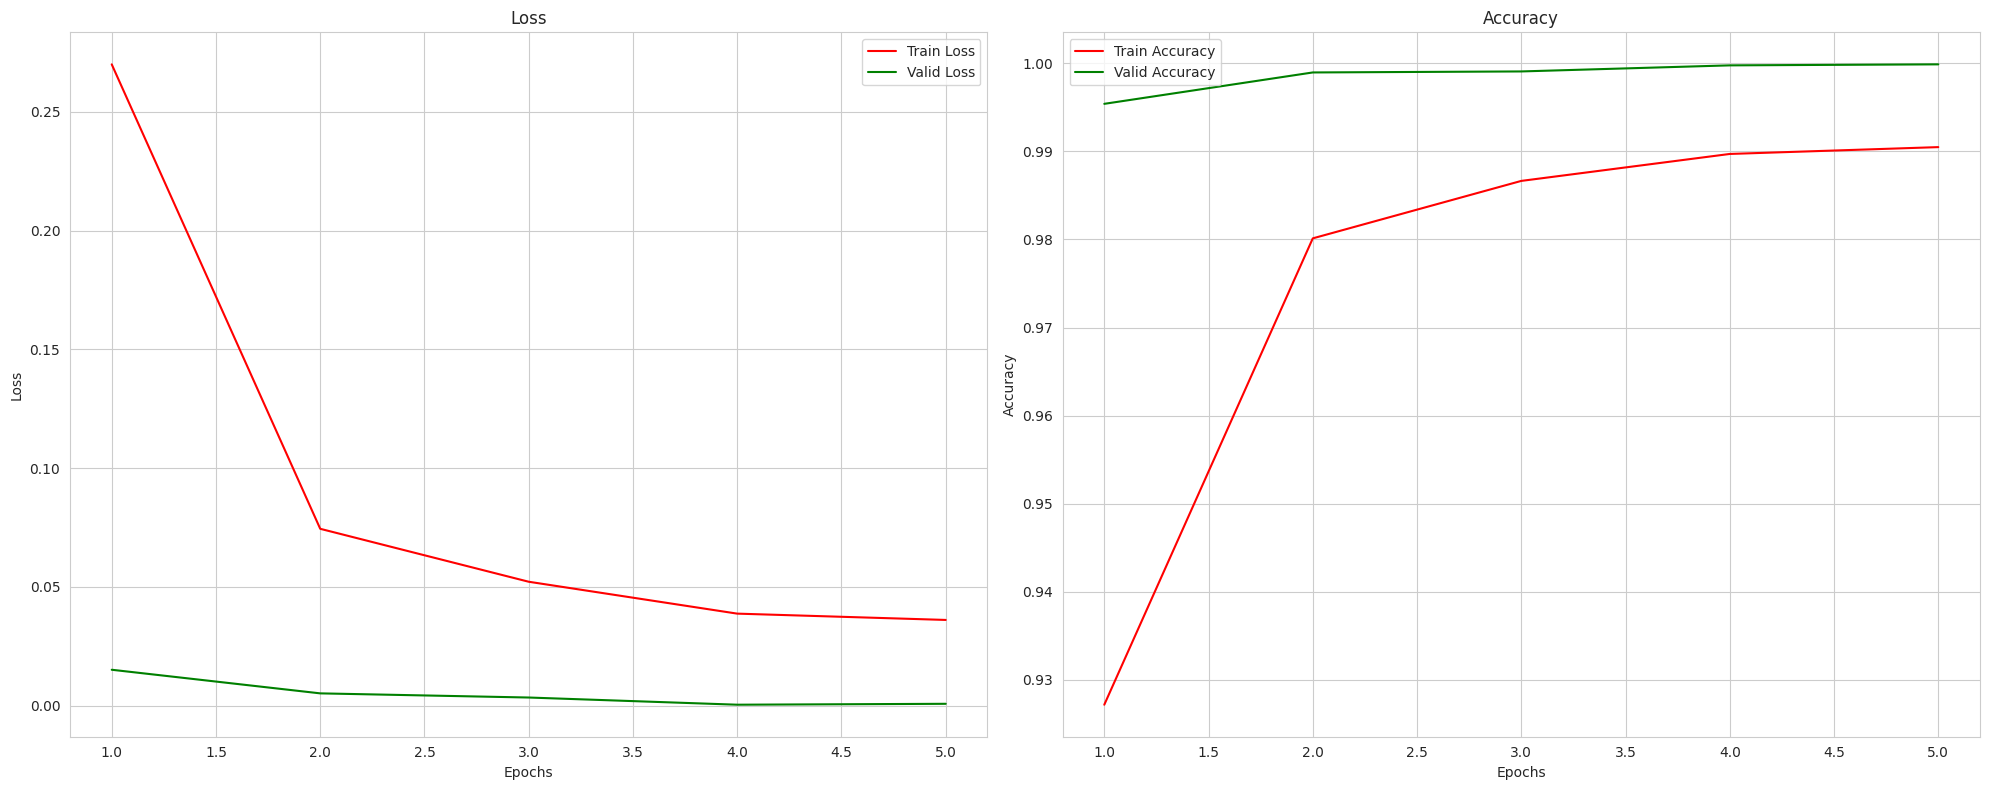

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()